# Style

En esta Notebook, nos concentramos en la extracción de features de la imagen de style. Para facilitar la comparación con el artículo, utilisare la noche estrellada y luego repetire lo mismo para composition-vii de Kandinsky que utlise para estilo en el trabajo final. 

Conceptualmente, lo mas profundo vamos en accumular profuniddad en VGG-net19, lo mas grande es el campo perceptual, por lo tanto representamos estructura mas grande espacialmente y mas compleja de la imagen de estilo. Cabe mencionar que como estamos utilisando transfert learning de la Vgg-net19, estamos limitado al tamaño de sus filtros. En el caso del estilo, no es tan importante como para la content_loss pues la styel_loss esta basada en correlaciones. Lo comprobaremos cpn la noche estrelalda y en partiuclar con Kandinsky composition-7 que tenemos en dos resoluciones muy differentes. Se notara diferencia en estructura fina pero el resulatdo de lato nivel es comparable. 

En todo los casos empezamos con una imagen de ruido blanco uniforme. Para estructura mas compleja y grande, el hecho de trabajar inicialmente con una imagen de ruido translada un efecto de granulación que suivizamos con el uso de la total_variation_loss; en particular ver corridas "Style_block5_conv1 con weight total variation loss = 0 " y "Style_block5_conv1 con weight total variation loss = 0.02". 

Un detalle en relación a los colores: Como trabajamos solamente con la imagen de estilo, en lugar de utilizar el promedio de la imagen de la Vgg-net19 en deprocessing, le puse el promedio de la imagen de estilo. Si uno vea la Figura 1 del artículo, debe habar hecho algo por el estilo pues es claro que los colores estas preservados en la salida de la red convolucional que se ven en la Figura 1 (ver abajo); si uno utilisa el promedio de las imagenes de entrenamiento de la VGG-net, no da tan lindo.  


In [1]:
# Creamos el directorio para los archivos de salida
#!mkdir /content/output
folder = 'D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content/'

In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
# Definimos la imagen que vamos a utilizar, y el directorio de salida

style_image_path = f'{folder}La_noche_estrellada1.jpg'
# style_image_path = f'{folder}composition-vii.jpg'
result_prefix = f'{folder}output/Style_block5_conv1_224/'
iterations = 30

In [4]:
total_variation_weight = 0.02
style_weight = 1

In [5]:
# Definimos el tamaño de las imágenes a utilizar, se genera la imagen de ruido y se 
# captura el promedio de los canales de colores de la imagen de estilo
width, height = load_img(style_image_path).size
# img_nrows = int(height/4)
img_nrows = 400
img_ncols = int(width * img_nrows / height)
noise_matrix = np.random.uniform(0,255,size=(height,width,3))
noise = np.clip(noise_matrix, 0, 255).astype('uint8')
save_img(f'{folder}white_noise_image.jpg',noise)
noise_image_path = f'{folder}white_noise_image.jpg'
w = img_to_array(load_img(style_image_path , target_size=(img_nrows, img_ncols)))
list_media = np.mean(w, axis=tuple(range(w.ndim-1)))
list_media_r = list_media[0]
list_media_g = list_media[1]
list_media_b = list_media[2]

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [7]:
"""
Se reemplaza los valores medio por los promedios de los colores de la imagen de estilo
"""
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    # x[:, :, 0] += 103.939
    # x[:, :, 1] += 116.779
    # x[:, :, 2] += 123.68
    x[:, :, 0] += list_media[2]
    x[:, :, 1] += list_media[1]
    x[:, :, 2] += list_media[0]
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
style_image = K.variable(preprocess_image(style_image_path))

In [9]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [10]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([style_image,combination_image], axis=0)

In [11]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False,pooling='avg')
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [13]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    Ml2 = int(style.shape[0] * style.shape[1])**2
    Nl2 = int(style.shape[2])**2 
    return K.sum(K.square(S - C)) / (4.0 * Nl2 * Ml2)

In [14]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [15]:
# Armamos la loss total
loss = K.variable(0.0)
# feature_layers = ['block1_conv1']
# feature_layers = ['block1_conv1', 'block2_conv1']
# feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1']
# feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1']
feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[0, :, :, :] 
    combination_features = layer_features[1, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [16]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [17]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [18]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

Start of iteration 0
Current loss value: 648793860.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content/output/Style_block5_conv1_224/block5_conv1_at_iteration_0.png
Iteration 0 completed in 26s
Start of iteration 1
Current loss value: 252492260.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content/output/Style_block5_conv1_224/block5_conv1_at_iteration_1.png
Iteration 1 completed in 27s
Start of iteration 2
Current loss value: 152016830.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content/output/Style_block5_conv1_224/block5_conv1_at_iteration_2.png
Iteration 2 completed in 27s
Start of iteration 3
Current loss value: 106991540.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content/output/Style_block5_conv1_224/block5_conv1_at_iteration_3.png
Iteration 3 completed in 27s
Start of iteration 4
Current loss value: 83892890.0
Image saved as D:/Marc/Anaconda/Trabajo _final_Computer_Vision/content/output/Style_bloc

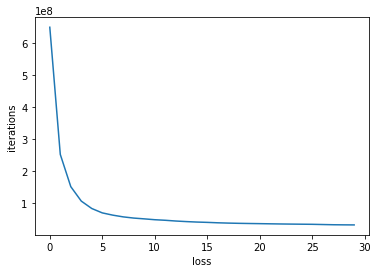

In [19]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
# x = preprocess_image(style_image_path)
x = preprocess_image(noise_image_path)
loss_graficar = []

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    loss_graficar.append(min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    # fname = result_prefix / ('output_at_iteration_%d.png' % i)
    d = i
    fname = f'{result_prefix}{feature_layers[len(feature_layers)-1]}_at_iteration_{d}.png'
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
plt.plot(loss_graficar)
plt.xlabel('loss')
plt.ylabel('iterations')
plt.savefig(f'{result_prefix}loss_graficar.png')
plt.show() 

Figure 1 del artículo 

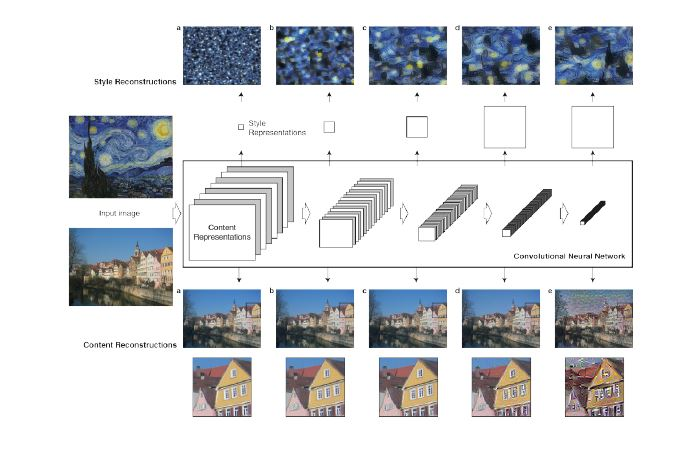

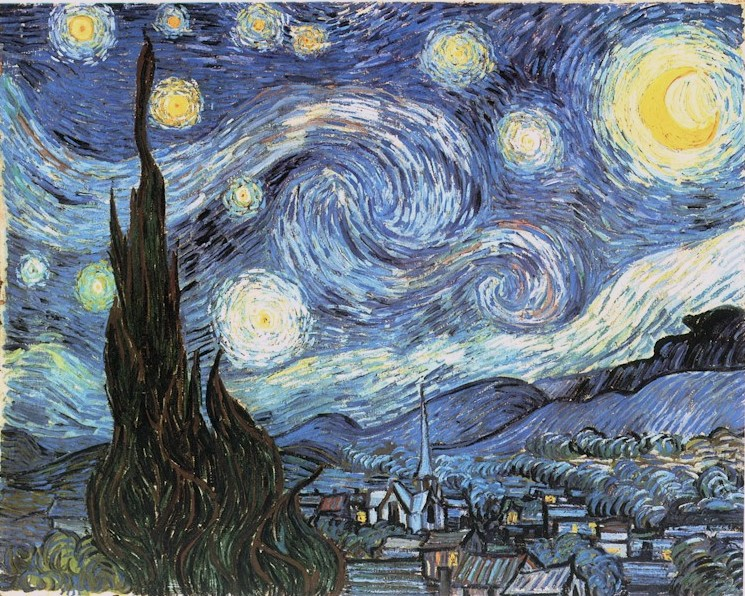

Style_block1_conv1:  corresponde a feature_layers = ['block1_conv1'] 

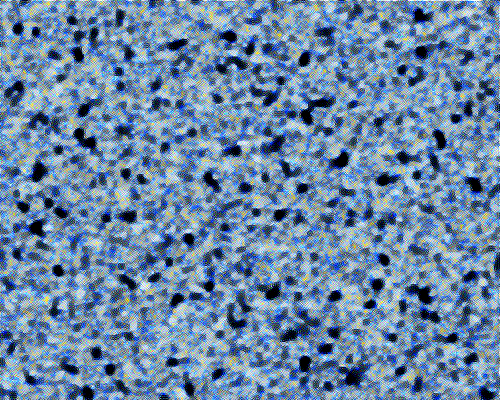

Style_block2_conv1:  corresponde a feature_layers = ['block1_conv1', 'block2_conv1'] 

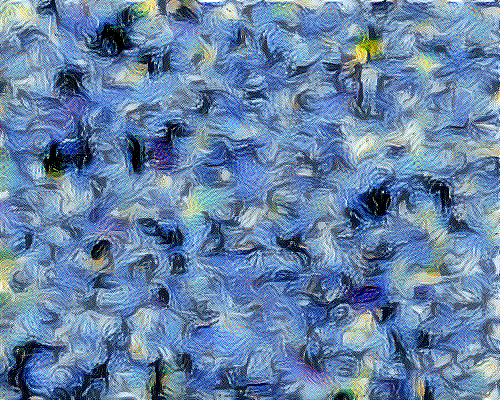

Style_block3_conv1: corresponde a feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1']

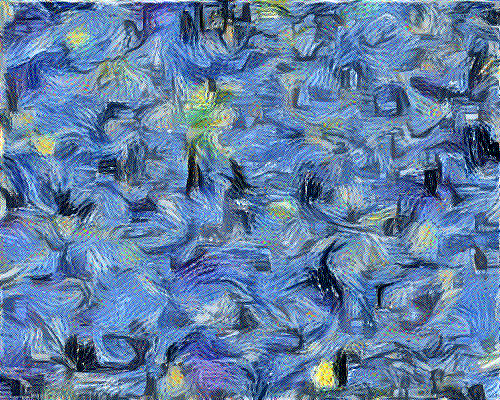

Style_block4_conv1: corresponde a feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1']

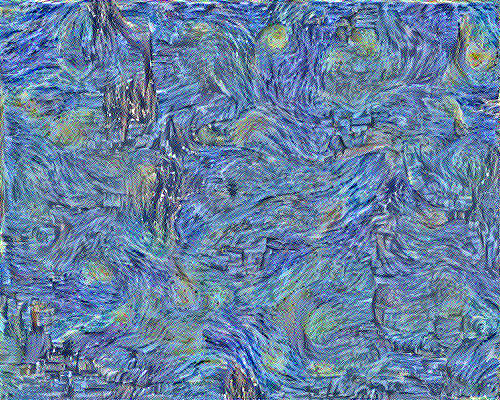

Style_block5_conv1 con weight total_variation_loss = 0: corresponde a feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1'] En este caso, tal como en el anterior, hay estructura fina que probablemente proviene de la estructura de la imagen de input y que no representan fidedignamente la estructura capturada por los layers de la VGG-net19. Por eso, repetimos la misma calculación abajo de esta pero sumando a la style_loss la total_variation_loss para eliminar estos artefactos. 

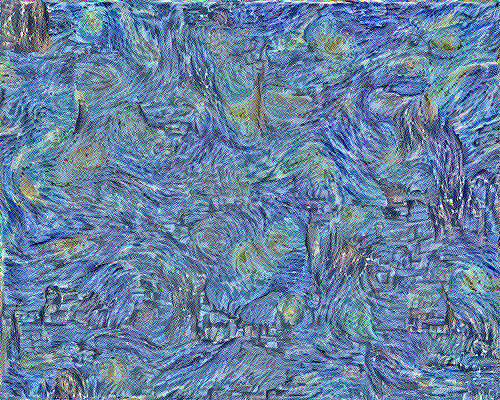

Style_block5_conv1  con weight total_variation_loss = 0.02: corresponde a feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']

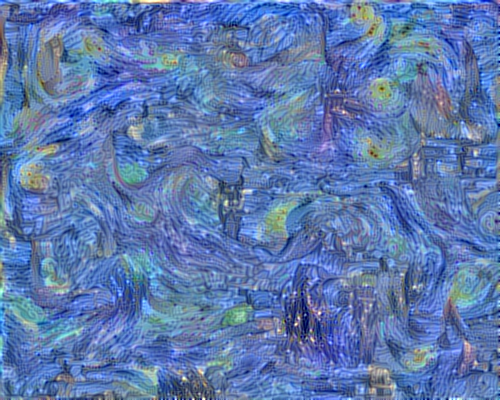

Style_block5_conv1 con weight total_variation_loss = 0.1 y resolución de 224.: corresponde a feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1'] per con una mimagen de ruida de menor resolución (height = 224). Se ve a que agrande rasgo, el resultado es similar a pesar del cambio de resolución. 

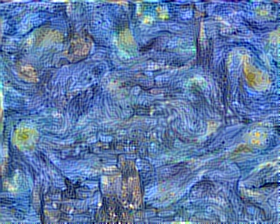

Style_block5_Kandinsky_full con weight total_variation_loss = 0.1;  corresponde a feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']. Comparar con la imagen posterior de igual paranmetro pero de resolución mucho mas beja.  Es una representación, desde una imagen de esta resolución, del resultado de estas capas creada bajo la minimización dela la style_loss.
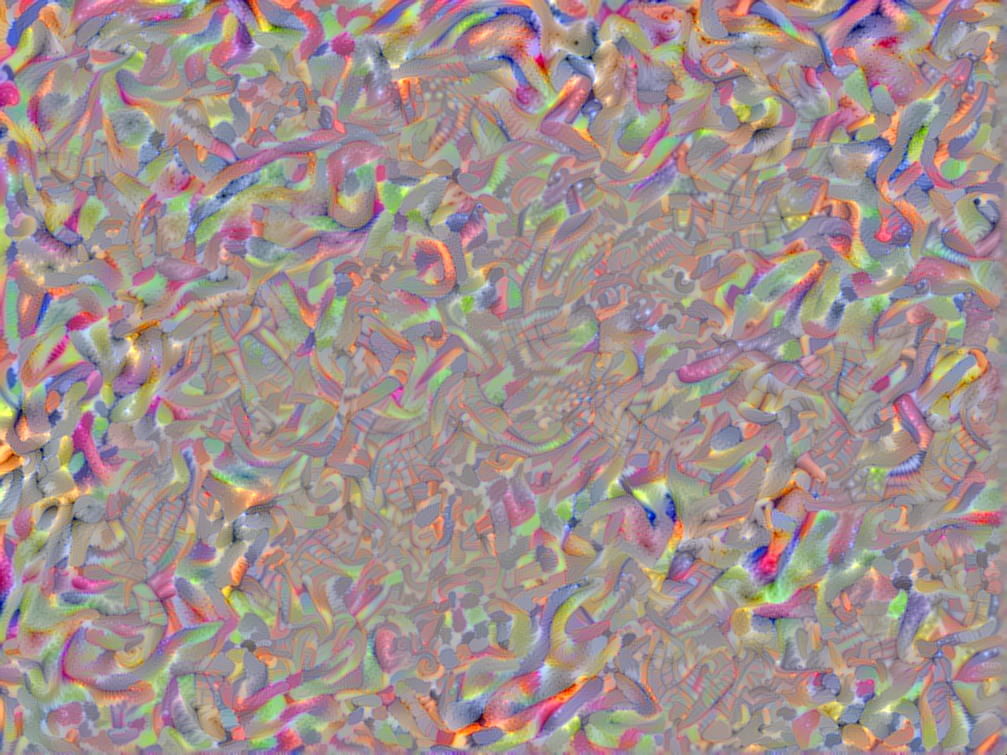

Style_block5_Kandinsky_224 con weight total_variation_loss = 0.1;  corresponde a feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']. Comparando con el anterior, vemos estructura similar pero mas definida y brillante. Es una representación precisa del resultado de estas capas creada bajo la minimización dela  la style_loss. 

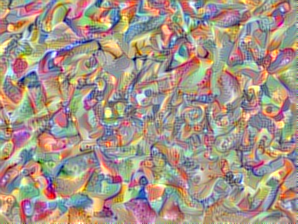